In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [56]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor
from src.dbc import utils
from IPython.display import clear_output
import src.utils as ut

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

In [86]:
fee = calc.fee
public_bill = calc.public_bill
public_bill

2640560

In [87]:
_public_bill = public_bill / len(month_df)
_public_bill

24449.62962962963

## Cluster Pattern Parsing

In [7]:
m_15 = utils.data_preprocessing(xlsx)

df = utils.dimension_reduction(m_15)
m_60 = df.copy()

m_60.head()

# 1월치 데이터 파싱
m_15_1 = m_15[m_15.index.month == 1].copy()
m_15_1.head()

m_60_1 = m_60[m_60.index.month == 1].copy()
m_60_1.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2019-01-01 00:00:00,0.033,0.000,0.034,0.037,0.062,0.322,0.240,0.295,0.373,0.243,...,0.534,0.188,0.400,0.318,0.420,0.626,0.484,0.289,0.305,0.652
2019-01-01 01:00:00,0.048,0.000,0.033,0.037,0.063,0.185,0.257,0.397,0.257,0.228,...,0.396,0.434,0.355,0.250,0.465,0.409,0.459,0.336,0.332,0.557
2019-01-01 02:00:00,0.032,0.000,0.039,0.036,0.062,0.175,0.384,0.353,0.123,0.141,...,0.194,0.337,0.379,0.274,0.326,0.307,0.405,0.382,0.311,0.491
2019-01-01 03:00:00,0.033,0.000,0.039,0.037,0.062,0.167,0.276,0.488,0.142,0.159,...,0.286,0.263,0.375,0.264,0.336,0.345,0.298,0.291,0.261,0.511
2019-01-01 04:00:00,0.032,0.001,0.033,0.037,0.063,0.197,0.266,0.278,0.190,0.227,...,0.275,0.245,0.310,0.423,0.360,0.364,0.212,0.347,0.294,0.507


이상패턴 조정 확인 True


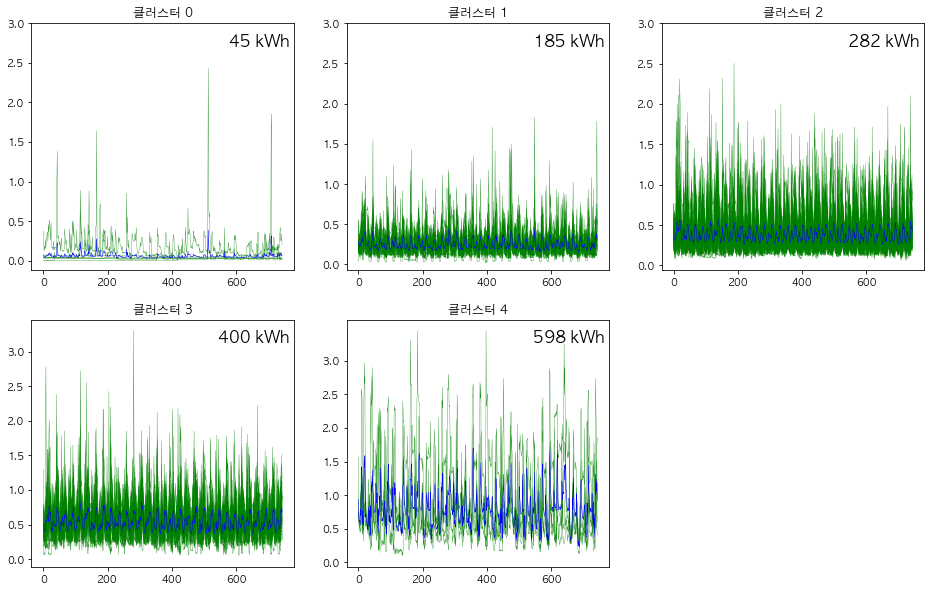

In [78]:
from src import SavingFeedback


wm_sf = SavingFeedback(xlsx, _type="tdkmeans")
wm_sf.select_month(1)
wm_sf.kmeans_run()

clear_output(wait=True)

# 3. adjust anomaly
wm_sf.adjust_anomaly()
anomaly = wm_sf.check_anomaly()
print("이상패턴 조정 확인", len(anomaly) == 0)

wm_sf.kmeans.draw_plot()

In [79]:
group_df = ut.make_group_df(m_60_1, wm_sf.kmeans.kmeans)

group_df

,가구명,usage (kWh),label
0,아파트1-104-1206,99,0
1,아파트1-104-303,10,0
2,아파트1-104-1307,23,0
3,아파트1-104-1208,40,0
4,아파트1-104-408,39,0
...,...,...,...
103,아파트1-103-903,273,2
104,아파트1-103-1106,255,2
105,아파트1-103-705,228,2
106,아파트1-103-1505,384,3


In [80]:
_month_df = np.column_stack([m_60_1.columns, m_60_1.sum(axis=0).values.round().astype("int")])
month_df = pd.DataFrame(_month_df, columns=['name', 'usage (kWh)'])

month_df

,name,usage (kWh)
0,아파트1-104-1206,99
1,아파트1-104-303,10
2,아파트1-104-1307,23
3,아파트1-104-1208,40
4,아파트1-104-408,39
...,...,...
103,아파트1-103-903,273
104,아파트1-103-1106,255
105,아파트1-103-705,228
106,아파트1-103-1505,384


In [81]:
labels, clusters = tdKMeans.labels_, tdKMeans.clusters_

_cluster_info = np.column_stack([month_df.values, labels])
cluster_info = pd.DataFrame(_cluster_info, columns=['name', 'usage (kWh)','그룹 번호'])

cluster_info.head(10)

,name,usage (kWh),그룹 번호
0,아파트1-104-1206,99,0
1,아파트1-104-303,10,0
2,아파트1-104-1307,23,0
3,아파트1-104-1208,40,0
4,아파트1-104-408,39,0
5,아파트1-104-203,197,1
6,아파트1-103-1402,218,1
7,아파트1-103-402,228,1
8,아파트1-103-1201,84,0
9,아파트1-103-801,223,1


In [82]:
_labels = np.unique(labels)
label_cnt = np.array([np.where(labels == _label)[0].size for _label in _labels])

_cont = np.column_stack([_labels, clusters.sum(axis=1).round().astype("int"),label_cnt])
cont = pd.DataFrame(_cont, columns=['그룹 번호', '클러스터 패턴 총 사용량','가구 수'])
cont.set_index("그룹 번호", inplace=True)

cont

,클러스터 패턴 총 사용량,가구 수
그룹 번호,,
0,53,8
1,194,24
2,285,45
3,400,27
4,598,4


In [89]:
cont_1 = cont.copy()

total_median = cont_1['클러스터 패턴 총 사용량'].sum()
cont_1['contribution'] = cont_1['클러스터 패턴 총 사용량'].map(lambda x: x / total_median)

cont_1

,클러스터 패턴 총 사용량,가구 수,contribution
그룹 번호,,,
0,53,8,0.034641
1,194,24,0.126797
2,285,45,0.186275
3,400,27,0.261438
4,598,4,0.390850


In [105]:
cont_1.sum(axis=0)

클러스터 패턴 총 사용량    1530.0
가구 수              108.0
contribution        1.0
dtype: float64

In [90]:
_public_bill = round(public_bill / len(cluster_info))
_public_bill

24450

In [91]:
simple_dist_1 = cont_1.copy()

simple_dist_1['공용부 요금'] = simple_dist_1['가구 수'].map(lambda x: x * _public_bill)
simple_dist_1['단순 가격분배'] = (simple_dist_1['공용부 요금'] * simple_dist_1['contribution']).round().astype("int")

simple_dist_1['가구 별 분배 가격'] = simple_dist_1.apply(lambda x: int(x['단순 가격분배'] / x['가구 수']), axis=1)

simple_dist_1

,클러스터 패턴 총 사용량,가구 수,contribution,공용부 요금,단순 가격분배,가구 별 분배 가격
그룹 번호,,,,,,
0,53,8,0.034641,195600,6776,847
1,194,24,0.126797,586800,74405,3100
2,285,45,0.186275,1100250,204949,4554
3,400,27,0.261438,660150,172588,6392
4,598,4,0.390850,97800,38225,9556


In [92]:
simple_info_1 = cluster_info.copy()

simple_info_1['단순 가격분배'] = simple_info_1['그룹 번호'].map(
        lambda x: int(simple_dist_1.loc[x]['가구 별 분배 가격'])
)

simple_info_1['공용부 요금 나머지'] = round((public_bill - simple_info_1['단순 가격분배'].sum()) / len(cluster_info))
simple_info_1['최종 공용부 요금'] = simple_info_1['단순 가격분배'] + simple_info_1['공용부 요금 나머지']

simple_info_1.head(10)

,name,usage (kWh),그룹 번호,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
0,아파트1-104-1206,99,0,847,19849,20696
1,아파트1-104-303,10,0,847,19849,20696
2,아파트1-104-1307,23,0,847,19849,20696
3,아파트1-104-1208,40,0,847,19849,20696
4,아파트1-104-408,39,0,847,19849,20696
5,아파트1-104-203,197,1,3100,19849,22949
6,아파트1-103-1402,218,1,3100,19849,22949
7,아파트1-103-402,228,1,3100,19849,22949
8,아파트1-103-1201,84,0,847,19849,20696
9,아파트1-103-801,223,1,3100,19849,22949


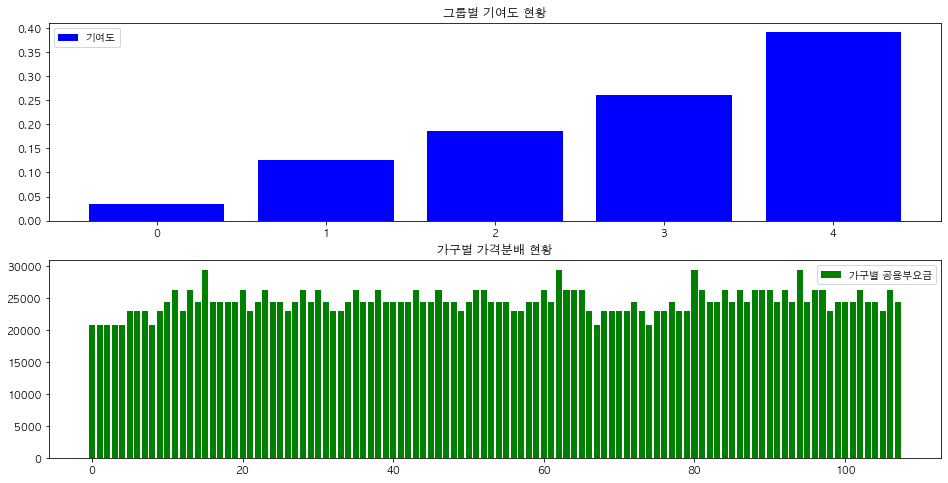

In [93]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(simple_dist_1)), simple_dist_1['contribution'], color='b', label='기여도')
ax_1.set_title("그룹별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(simple_info_1)), simple_info_1['최종 공용부 요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [94]:
min_h = simple_info_1[simple_info_1['name'] == '아파트1-104-905']
mean_h = simple_info_1[simple_info_1['name'] == '아파트1-102-801']
max_h = simple_info_1[simple_info_1['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),그룹 번호,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
69,아파트1-104-905,148,1,3100,19849,22949
44,아파트1-102-801,280,2,4554,19849,24403
15,아파트1-102-903,711,4,9556,19849,29405


In [95]:
# 예측 시뮬레이션
pp = PublicPredictor(
    APT=APT,
    month_df=month_df[['name', 'usage (kWh)']],
    month=_month
)
pp.predict

실제 요금    2640560
예측 요금    2639700
오차           860
dtype: int64

In [96]:
col_df = cont.copy()

col_df['공용부 기본요금'] = (round(pp.basic / len(month_df)) * col_df['가구 수']).round().astype("int")
col_df['공용부 전력량요금'] = round(pp.elec_rate / len(month_df)) * col_df['가구 수'].round().astype("int")

col_df

,클러스터 패턴 총 사용량,가구 수,공용부 기본요금,공용부 전력량요금
그룹 번호,,,,
0,53,8,34016,132752
1,194,24,102048,398256
2,285,45,191340,746730
3,400,27,114804,448038
4,598,4,17008,66376


In [97]:
dist_1 = pd.concat([cont_1, col_df[col_df.columns[-2:]]], axis=1)

dist_1['기여도 공용부 기본요금'] = (dist_1['공용부 기본요금'] * dist_1['contribution']).round().astype("int")
dist_1['기여도 공용부 전력량요금'] = (dist_1['공용부 전력량요금'] * dist_1['contribution']).round().astype("int")
dist_1['기여도 공용부 요금'] = dist_1['기여도 공용부 기본요금'] + dist_1['기여도 공용부 전력량요금']
dist_1['가구 별 분배 가격'] = (dist_1['기여도 공용부 요금'] / dist_1['가구 수']).round().astype("int")

dist_1

,클러스터 패턴 총 사용량,가구 수,contribution,공용부 기본요금,공용부 전력량요금,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부 요금,가구 별 분배 가격
그룹 번호,,,,,,,,,
0,53,8,0.034641,34016,132752,1178,4599,5777,722
1,194,24,0.126797,102048,398256,12939,50498,63437,2643
2,285,45,0.186275,191340,746730,35642,139097,174739,3883
3,400,27,0.261438,114804,448038,30014,117134,147148,5450
4,598,4,0.390850,17008,66376,6648,25943,32591,8148


In [98]:
dist_info_1 = cluster_info.copy()

dist_info_1['단순 가격분배'] = dist_info_1['그룹 번호'].map(
        lambda x: int(dist_1.loc[x]['가구 별 분배 가격'])
)

dist_info_1['공용부 요금 나머지'] = round((public_bill - dist_info_1['단순 가격분배'].sum()) / len(dist_info_1))
dist_info_1['최종 공용부 요금'] = dist_info_1['단순 가격분배'] + dist_info_1['공용부 요금 나머지']

dist_info_1.head(10)

,name,usage (kWh),그룹 번호,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
0,아파트1-104-1206,99,0,722,20527,21249
1,아파트1-104-303,10,0,722,20527,21249
2,아파트1-104-1307,23,0,722,20527,21249
3,아파트1-104-1208,40,0,722,20527,21249
4,아파트1-104-408,39,0,722,20527,21249
5,아파트1-104-203,197,1,2643,20527,23170
6,아파트1-103-1402,218,1,2643,20527,23170
7,아파트1-103-402,228,1,2643,20527,23170
8,아파트1-103-1201,84,0,722,20527,21249
9,아파트1-103-801,223,1,2643,20527,23170


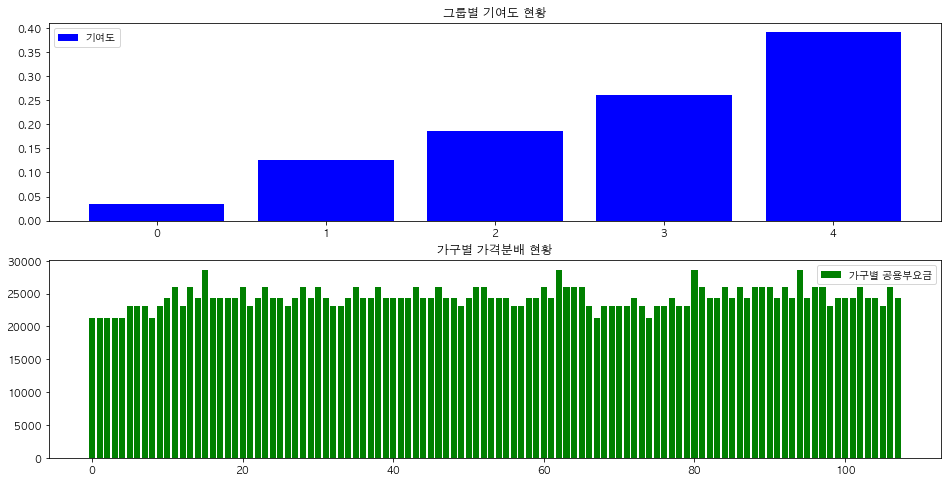

In [99]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(dist_1)), dist_1['contribution'], color='b', label='기여도')
ax_1.set_title("그룹별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(dist_info_1)), dist_info_1['최종 공용부 요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [100]:
min_h = dist_info_1[dist_info_1['name'] == '아파트1-104-905']
mean_h = dist_info_1[dist_info_1['name'] == '아파트1-102-801']
max_h = dist_info_1[dist_info_1['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),그룹 번호,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
69,아파트1-104-905,148,1,2643,20527,23170
44,아파트1-102-801,280,2,3883,20527,24410
15,아파트1-102-903,711,4,8148,20527,28675


In [101]:
norm_dist = cont_1.copy()

norm_dist['contribution'] = (norm_dist['contribution'] - norm_dist['contribution'].min()) / \
                    (norm_dist['contribution'].max() - norm_dist['contribution'].min())

norm_dist = pd.concat([norm_dist, col_df[col_df.columns[-2:]]], axis=1)

norm_dist['기여도 공용부 기본요금'] = (norm_dist['공용부 기본요금'] * norm_dist['contribution']).round().astype("int")
norm_dist['기여도 공용부 전력량요금'] = (norm_dist['공용부 전력량요금'] * norm_dist['contribution']).round().astype("int")
norm_dist['기여도 공용부 요금'] = norm_dist['기여도 공용부 기본요금'] + norm_dist['기여도 공용부 전력량요금']
norm_dist['가구 별 분배 가격'] = (norm_dist['기여도 공용부 요금'] / norm_dist['가구 수']).round().astype("int")

norm_dist

,클러스터 패턴 총 사용량,가구 수,contribution,공용부 기본요금,공용부 전력량요금,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부 요금,가구 별 분배 가격
그룹 번호,,,,,,,,,
0,53,8,0.000000,34016,132752,0,0,0,0
1,194,24,0.258716,102048,398256,26401,103035,129436,5393
2,285,45,0.425688,191340,746730,81451,317874,399325,8874
3,400,27,0.636697,114804,448038,73095,285265,358360,13273
4,598,4,1.000000,17008,66376,17008,66376,83384,20846


In [102]:
norm_dist_info = cluster_info.copy()

norm_dist_info['단순 가격분배'] = norm_dist_info['그룹 번호'].map(
        lambda x: int(norm_dist.loc[x]['가구 별 분배 가격'])
)

norm_dist_info['공용부 요금 나머지'] = round((public_bill - norm_dist_info['단순 가격분배'].sum()) / len(norm_dist_info))
norm_dist_info['최종 공용부 요금'] = norm_dist_info['단순 가격분배'] + norm_dist_info['공용부 요금 나머지']

norm_dist_info.head(10)


,name,usage (kWh),그룹 번호,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
0,아파트1-104-1206,99,0,0,15463,15463
1,아파트1-104-303,10,0,0,15463,15463
2,아파트1-104-1307,23,0,0,15463,15463
3,아파트1-104-1208,40,0,0,15463,15463
4,아파트1-104-408,39,0,0,15463,15463
5,아파트1-104-203,197,1,5393,15463,20856
6,아파트1-103-1402,218,1,5393,15463,20856
7,아파트1-103-402,228,1,5393,15463,20856
8,아파트1-103-1201,84,0,0,15463,15463
9,아파트1-103-801,223,1,5393,15463,20856


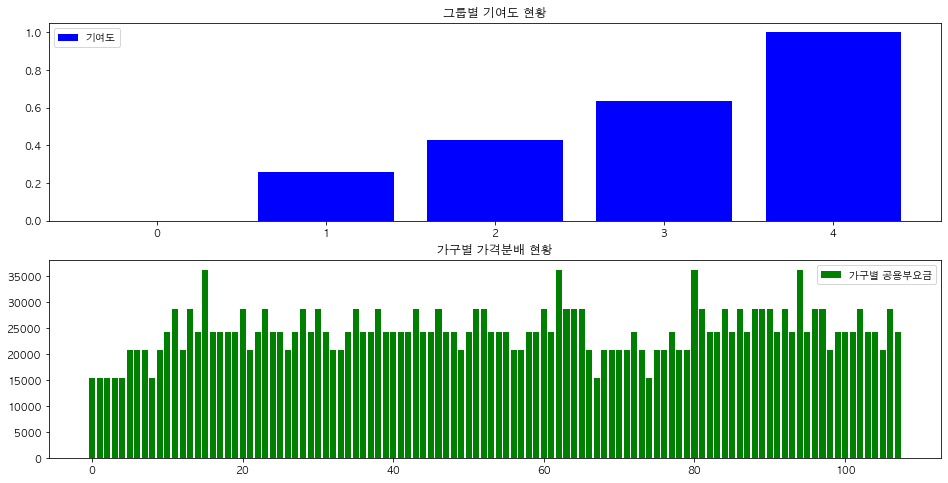

In [103]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(dist_1)), norm_dist['contribution'], color='b', label='기여도')
ax_1.set_title("그룹별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(dist_info_1)), norm_dist_info['최종 공용부 요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [104]:
min_h = norm_dist_info[norm_dist_info['name'] == '아파트1-104-905']
mean_h = norm_dist_info[norm_dist_info['name'] == '아파트1-102-801']
max_h = norm_dist_info[norm_dist_info['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),그룹 번호,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
69,아파트1-104-905,148,1,5393,15463,20856
44,아파트1-102-801,280,2,8874,15463,24337
15,아파트1-102-903,711,4,20846,15463,36309
